<a href="https://colab.research.google.com/github/RedFiringSun/SchemaSquad/blob/main/CS226_Big_Data_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pyspark

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
import os
import zipfile
import folium
from folium.plugins import HeatMap
import pandas as pd

spark = SparkSession.builder \
    .appName("Yelp Heatmap Analysis") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "10") \
    .config("spark.default.parallelism", "10") \
    .getOrCreate()

def process_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"\nExtracted ZIP contents to: {extract_to}")
    return [os.path.join(extract_to, file) for file in os.listdir(extract_to) if file.endswith('.json')]

zip_file_path = '/content/drive/MyDrive/BigData/SchemaSquad/archive.zip'
extract_dir = '/content/drive/MyDrive/BigData/SchemaSquad'
os.makedirs(extract_dir, exist_ok=True)
json_files = process_zip(zip_file_path, extract_dir)

business_file = [file for file in json_files if 'yelp_academic_dataset_business.json' in file][0]
df_business = spark.read.json(business_file)
df_locations = df_business.select("name", "latitude", "longitude", "stars").dropna()

df_locations = df_locations.filter((df_locations.latitude.isNotNull()) & (df_locations.longitude.isNotNull()))

pdf_locations = df_locations.toPandas()
print(pdf_locations.head())

map_center = [pdf_locations['latitude'].mean(), pdf_locations['longitude'].mean()]
heatmap_map = folium.Map(location=map_center, zoom_start=10)
heat_data = pdf_locations[['latitude', 'longitude', 'stars']].values.tolist()
HeatMap(heat_data, radius=10).add_to(heatmap_map)
heatmap_map.save("yelp_heatmap.html")
print("Heatmap saved as yelp_heatmap.html.")

KeyboardInterrupt: 

In [ ]:
from pyspark.sql.functions import col, lower
import folium

categories = ["restaurants", "beauty & spas", "coffee & tea", "automotive", "health & medical"]
for category in categories:
    category_data = df_business.filter(lower(col("categories")).contains(category.lower()))
    category_pdf = category_data.select("city", "stars", "latitude", "longitude").toPandas()
    city_ratings = category_pdf.groupby('city').agg({
        'stars': 'mean',
        'latitude': 'mean',
        'longitude': 'mean'
    }).reset_index()

    if city_ratings.empty:
        print(f"No data found for category: {category}")
        continue
    category_map = folium.Map(
        location=[city_ratings['latitude'].mean(), city_ratings['longitude'].mean()],
        zoom_start=6
    )

    for _, row in city_ratings.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=7,
            color='blue' if row['stars'] >= 4 else 'red',
            fill=True,
            fill_color='blue' if row['stars'] >= 4 else 'red',
            fill_opacity=0.6,
            popup=f"{row['city']} - {row['stars']:.1f} stars"
        ).add_to(category_map)

    category_filename = f"{category.replace('&', 'and').replace(' ', '_')}_choropleth_map.html"
    category_map.save(category_filename)
    print(f"Map saved as {category_filename}")


Map saved as restaurants_choropleth_map.html
Map saved as beauty_and_spas_choropleth_map.html
Map saved as coffee_and_tea_choropleth_map.html
Map saved as automotive_choropleth_map.html
Map saved as health_and_medical_choropleth_map.html


In [ ]:
file_path = '/content/drive/MyDrive/BigData/SchemaSquad/stgdppi2q24.xlsx'
df_raw = pd.read_excel(file_path, skiprows=6)
print(df_raw.head(15))
regions_to_exclude = ["United States", "Northeast", "Mideast", "Great Lakes", "West", "South"]
df_states = df_raw[~df_raw.iloc[:, 0].isin(regions_to_exclude)]

df_states = df_states.rename(columns={
    df_states.columns[0]: "State",
    df_states.columns[2]: "GDP_2023",
    df_states.columns[3]: "GDP_2024"
})

df_states = df_states[["State", "GDP_2023", "GDP_2024"]]

df_states = df_states.dropna(subset=["GDP_2023", "GDP_2024"])

df_states["GDP_2023"] = pd.to_numeric(df_states["GDP_2023"], errors="coerce")
df_states["GDP_2024"] = pd.to_numeric(df_states["GDP_2024"], errors="coerce")
df_states.reset_index(drop=True, inplace=True)

print(df_states.head())

            United States   26006893   27720709   28296967   28624069  \
0            New England   1324161.0  1410687.0  1440641.0  1467183.0   
1             Connecticut   321686.0   345912.0   355246.0   358594.0   
2                  Maine     86493.0    93270.0    95468.0    96860.0   
3          Massachusetts    695612.0   736296.0   749677.0   767359.0   
4          New Hampshire    106488.0   114101.0   116529.0   118760.0   
5           Rhode Island     72869.0    77574.0    79122.0    80839.0   
6                Vermont     41012.0    43534.0    44598.0    44771.0   
7                Mideast   4474023.0  4745213.0  4833144.0  4895879.0   
8               Delaware     92558.0    98069.0   100184.0   100918.0   
9   District of Columbia    165768.0   176502.0   180537.0   182190.0   
10              Maryland    484908.0   515607.0   525753.0   532514.0   
11             New Jersey   758289.0   806665.0   822849.0   831387.0   
12               New York  2052759.0  2172010.0  22

In [ ]:
from pyspark.sql.functions import count

for category in categories:
    category_data = df_business.filter(lower(col("categories")).contains(category.lower()))

    top_cities = category_data.groupBy("city").agg(count("*").alias("business_count")).orderBy(col("business_count").desc())
    print(f"\nTop 10 cities for category: {category}")
    top_cities.show(10)



Top 10 cities for category: restaurants
+------------+--------------+
|        city|business_count|
+------------+--------------+
|Philadelphia|          5852|
|       Tampa|          2960|
|Indianapolis|          2862|
|   Nashville|          2502|
|      Tucson|          2466|
| New Orleans|          2259|
|    Edmonton|          2166|
| Saint Louis|          1790|
|        Reno|          1286|
|       Boise|           847|
+------------+--------------+
only showing top 10 rows


Top 10 cities for category: beauty & spas
+-------------+--------------+
|         city|business_count|
+-------------+--------------+
| Philadelphia|          1320|
|       Tucson|           930|
|        Tampa|           925|
|    Nashville|           606|
| Indianapolis|           595|
|         Reno|           578|
|     Edmonton|           454|
|  New Orleans|           436|
|Santa Barbara|           400|
|  Saint Louis|           390|
+-------------+--------------+
only showing top 10 rows


Top 10 ci

In [ ]:
from pyspark.sql.functions import avg

for category in categories:
    category_data = df_business.filter(lower(col("categories")).contains(category.lower()))
    state_avg_ratings = category_data.groupBy("state").agg(avg("stars").alias("average_rating")).orderBy(col("average_rating").desc())
    print(f"\nAverage ratings by state for category: {category}")
    state_avg_ratings.show(10)



Average ratings by state for category: restaurants
+-----+------------------+
|state|    average_rating|
+-----+------------------+
|   MT|               5.0|
|  XMS|               4.0|
|   CA|3.7627045650301465|
|   LA|3.5951923076923076|
|   FL| 3.578341541633261|
|   ID| 3.544930875576037|
|   NV| 3.537955768081291|
|   PA|3.5215568388576854|
|   CO|               3.5|
|   HI|               3.5|
+-----+------------------+
only showing top 10 rows


Average ratings by state for category: beauty & spas
+-----+------------------+
|state|    average_rating|
+-----+------------------+
|   TX|               5.0|
|   SD|               4.5|
|   CA| 4.319607843137255|
|   NV|4.1022058823529415|
|   FL| 3.909175680716151|
|   ID|3.8891402714932126|
|   LA|          3.861875|
|   AZ|3.8423423423423424|
|   TN|3.8010610079575597|
|   PA|3.7884671962341865|
+-----+------------------+
only showing top 10 rows


Average ratings by state for category: coffee & tea
+-----+------------------+
|state

In [ ]:
for category in categories:
    category_data = df_business.filter(lower(col("categories")).contains(category.lower()))
    city_ratings = category_data.groupBy("city").agg(
        avg("stars").alias("average_rating"),
        count("*").alias("business_count")
    ).filter(col("business_count") > 10).orderBy(col("average_rating").desc())
    print(f"\nCities with the highest-rated businesses for category: {category}")
    city_ratings.show(10)



Cities with the highest-rated businesses for category: restaurants
+--------------------+------------------+--------------+
|                city|    average_rating|business_count|
+--------------------+------------------+--------------+
|       Merchantville| 4.173076923076923|            26|
|    Saint Pete Beach| 4.076923076923077|            26|
|North Redington B...| 4.076923076923077|            13|
|          Barrington|            4.0625|            16|
|         Beech Grove|               4.0|            16|
|    Redington Shores|               4.0|            12|
|        Tierra Verde|3.9642857142857144|            14|
|            Gulfport| 3.963636363636364|            55|
|           Montecito| 3.962962962962963|            27|
|       Garnet Valley|3.9615384615384617|            13|
+--------------------+------------------+--------------+
only showing top 10 rows


Cities with the highest-rated businesses for category: beauty & spas
+--------------+-----------------+----

Correlation between review count and stars for restaurants: 0.16
Correlation between review count and stars for beauty & spas: 0.03
Correlation between review count and stars for coffee & tea: 0.17
Correlation between review count and stars for automotive: -0.07
Correlation between review count and stars for health & medical: -0.01


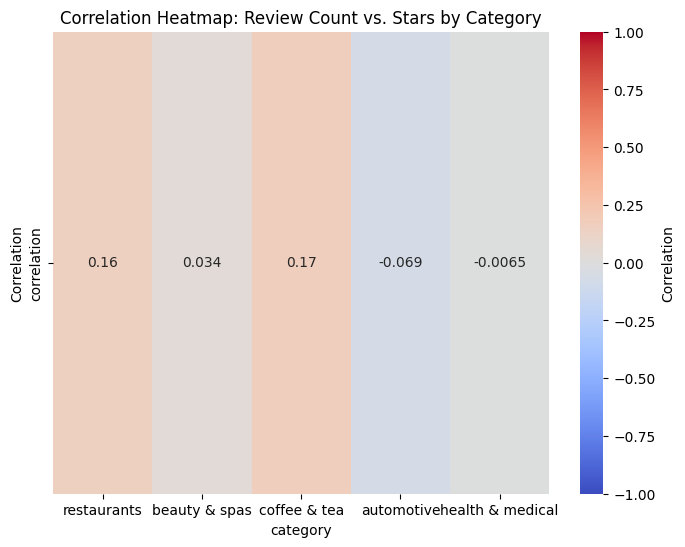

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, lower, corr
import pandas as pd

correlation_data = []
categories = ["restaurants", "beauty & spas", "coffee & tea", "automotive", "health & medical"]

for category in categories:
    category_data = df_business.filter(lower(col("categories")).contains(category.lower()))
    correlation = category_data.select(corr("review_count", "stars").alias("correlation")).collect()[0]["correlation"]
    correlation_data.append({"category": category, "correlation": correlation})
    print(f"Correlation between review count and stars for {category}: {correlation:.2f}")

correlation_df = pd.DataFrame(correlation_data)
correlation_pivot = correlation_df.set_index('category').T

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_pivot, annot=True, cmap="coolwarm", center=0, cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Review Count vs. Stars by Category')
plt.ylabel('Correlation')

plt.show()

In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd
pdf_locations['normalized_stars'] = (pdf_locations['stars'] - pdf_locations['stars'].min()) / \
                                    (pdf_locations['stars'].max() - pdf_locations['stars'].min())

map_center = [pdf_locations['latitude'].mean(), pdf_locations['longitude'].mean()]
color_coded_heatmap = folium.Map(location=map_center, zoom_start=10)
heat_data = pdf_locations[['latitude', 'longitude', 'normalized_stars']].values.tolist()

HeatMap(heat_data, radius=10, max_opacity=0.8, blur=15).add_to(color_coded_heatmap)

color_coded_heatmap.save("color_coded_heatmap.html")
print("Color-coded heatmap saved as color_coded_heatmap.html.")

Color-coded heatmap saved as color_coded_heatmap.html.


In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd
pdf_locations['normalized_stars'] = (pdf_locations['stars'] - pdf_locations['stars'].min()) / \
                                    (pdf_locations['stars'].max() - pdf_locations['stars'].min())
pdf_grouped = pdf_locations.groupby(['latitude', 'longitude'], as_index=False).agg({
    'normalized_stars': 'mean'
})
heat_data = pdf_grouped[['latitude', 'longitude', 'normalized_stars']].values.tolist()

map_center = [pdf_locations['latitude'].mean(), pdf_locations['longitude'].mean()]
improved_heatmap = folium.Map(location=map_center, zoom_start=10)

HeatMap(
    heat_data,
    radius=15,
    blur=20,
    max_opacity=0.8,
    gradient={
        0.0: 'blue',
        0.3: 'blue',
        0.6: 'blue',
        0.9: 'red',
        1.0: 'red'
    }
).add_to(improved_heatmap)

improved_heatmap.save("improved_improved_color_coded_heatmap.html")
print("Improved color-coded heatmap saved as improved_color_coded_heatmap.html.")

Improved color-coded heatmap saved as improved_color_coded_heatmap.html.


In [ ]:
top_locations = pdf_locations.groupby(['name']).agg({
    'stars': 'mean'
}).reset_index().sort_values(by='stars', ascending=False)

print("Top Locations by Average Rating:")
print(top_locations.head(10))

Top Locations by Average Rating:
                                                     name  stars
114116  ​​Transformational Abdominal Massage by Jada D...    5.0
70200                          Off The Leash Dog Grooming    5.0
70197                      Off Mane Street Salon & Barber    5.0
15567                                 Bruno David Gallery    5.0
70196                               Off Leash K9 Training    5.0
15563                            Brunelli Dental Partners    5.0
38369                    GBT Sheet Metal & Gutter Systems    5.0
38371                                            GCD Eats    5.0
38372                                   GCGC Greek Yogurt    5.0
38373                                   GCO Carpet Outlet    5.0


In [ ]:
df_business = df_business.toPandas()

In [ ]:
top_cities = df_business.groupby('city').agg({
    'stars': 'mean'
}).reset_index().sort_values(by='stars', ascending=False)

print("Top 10 Cities by Average Rating:")
print(top_cities.head(10))

Top 10 Cities by Average Rating:
                  city  stars
1074           Sparks,    5.0
830          POTTSTOWN    5.0
364            Fernley    5.0
822          Overbrook    5.0
114         Bridgeton     5.0
554   LOWER PROVIDENCE    5.0
1358      Yardley Boro    5.0
315           Edgemoor    5.0
65         Belleville     5.0
1286    Wesley Chapel     5.0


In [ ]:
business_density = df_business.groupby('city').size().reset_index(name='business_count')
business_density = business_density.sort_values(by='business_count', ascending=False)

print("Top 10 Cities by Business Density:")
print(business_density.head(10))

Top 10 Cities by Business Density:
               city  business_count
866    Philadelphia           14569
1210         Tucson            9250
1157          Tampa            9050
511    Indianapolis            7540
745       Nashville            6971
758     New Orleans            6209
926            Reno            5935
318        Edmonton            5054
989     Saint Louis            4827
1007  Santa Barbara            3829


In [ ]:
popular_categories = df_business.groupby(['city', 'categories']).size().reset_index(name='category_count')
popular_categories = popular_categories.sort_values(by='category_count', ascending=False)

print("Most Popular Business Categories by City:")
print(popular_categories)

Most Popular Business Categories by City:
                city                                         categories  \
75544   Philadelphia                                 Restaurants, Pizza   
74394   Philadelphia                                 Pizza, Restaurants   
75071   Philadelphia                               Restaurants, Chinese   
73595   Philadelphia                         Nail Salons, Beauty & Spas   
117102        Tucson                               Restaurants, Mexican   
...              ...                                                ...   
43021          Largo  Cuban, Latin American, Fast Food, Caribbean, R...   
43020          Largo  Couriers & Delivery Services, Home Services, J...   
43019          Largo  Cosmetics & Beauty Supply, Shopping, Beauty & ...   
43018          Largo  Cosmetics & Beauty Supply, Beauty & Spas, Conv...   
125267       ​Lithia            Doctors, Health & Medical, Orthopedists   

        category_count  
75544              154  
74394  

In [ ]:
top_categories = df_business.groupby('categories').agg({
    'stars': 'mean',
    'review_count': 'sum'
}).reset_index().sort_values(by='stars', ascending=False)

print("Top 10 Rated Business Categories:")
print(top_categories.head(10))

Top 10 Rated Business Categories:
                                              categories  stars  review_count
6186   Auto Repair, Auto Customization, Auto Glass Se...    5.0             7
29140  Fitness & Instruction, Gyms, Interval Training...    5.0            22
29162  Fitness & Instruction, Health & Medical, Healt...    5.0            10
29161  Fitness & Instruction, Health & Medical, Gyms,...    5.0             5
74147  Shopping, Shoe Stores, Men's Clothing, Fashion...    5.0            36
7550                     Automotive, Roadside Assistance    5.0             5
7551        Automotive, Roadside Assistance, Auto Repair    5.0             5
29157  Fitness & Instruction, Health & Medical, Activ...    5.0             7
29155  Fitness & Instruction, Health & Medical, Activ...    5.0             6
74140     Shopping, Shoe Stores, Fashion, Sporting Goods    5.0            11


In [ ]:
top_review_cities = df_business.groupby('city').agg({
    'review_count': 'sum'
}).reset_index().sort_values(by='review_count', ascending=False)

print("Top 10 Cities by Review Count:")
print(top_review_cities.head(10))

Top 10 Cities by Review Count:
               city  review_count
866    Philadelphia        936240
758     New Orleans        621361
745       Nashville        441053
1157          Tampa        439506
1210         Tucson        387254
511    Indianapolis        349228
926            Reno        334610
1007  Santa Barbara        262853
989     Saint Louis        244360
91            Boise        101893


In [ ]:
business_by_state = df_business.groupby('state').size().reset_index(name='business_count')
business_by_state = business_by_state.sort_values(by='business_count', ascending=False)

print("Business Distribution by State:")
print(business_by_state.head(10))

Business Distribution by State:
   state  business_count
18    PA           34039
5     FL           26330
20    TN           12056
9     IN           11247
13    MO           10913
10    LA            9924
1     AZ            9912
16    NJ            8536
17    NV            7715
0     AB            5573


In [ ]:
df_business['hours'] = df_business['hours'].fillna('{}')
business_hours = df_business[['name', 'city', 'hours']]

print("Sample Business Hours Data:")
print(business_hours.head())

Sample Business Hours Data:
                       name           city  \
0  Abby Rappoport, LAC, CMQ  Santa Barbara   
1             The UPS Store         Affton   
2                    Target         Tucson   
3        St Honore Pastries   Philadelphia   
4  Perkiomen Valley Brewery     Green Lane   

                                               hours  
0                                                 {}  
1  (8:0-18:30, 0:0-0:0, 8:0-14:0, None, 8:0-18:30...  
2  (8:0-23:0, 8:0-22:0, 8:0-23:0, 8:0-22:0, 8:0-2...  
3  (7:0-21:0, 7:0-20:0, 7:0-21:0, 7:0-21:0, 7:0-2...  
4  (12:0-22:0, None, 12:0-22:0, 12:0-18:0, 16:0-2...  


<Figure size 1000x600 with 0 Axes>

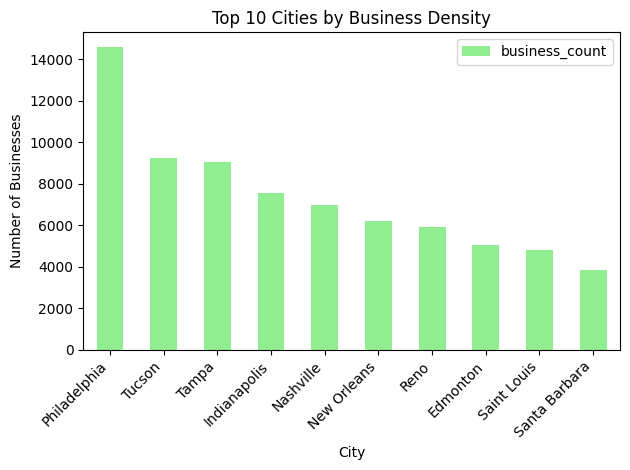

In [ ]:
business_density = df_business.groupby('city').size().reset_index(name='business_count')
business_density = business_density.sort_values(by='business_count', ascending=False)

plt.figure(figsize=(10, 6))
business_density.head(10).plot(kind='bar', x='city', y='business_count', color='lightgreen')
plt.title("Top 10 Cities by Business Density")
plt.xlabel('City')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

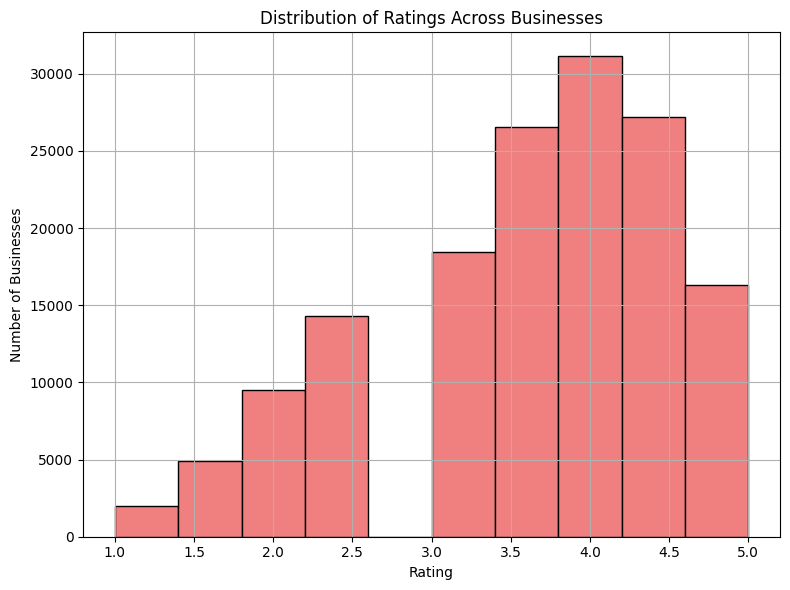

In [ ]:
plt.figure(figsize=(8, 6))
df_business['stars'].hist(bins=10, color='lightcoral', edgecolor='black')
plt.title("Distribution of Ratings Across Businesses")
plt.xlabel('Rating')
plt.ylabel('Number of Businesses')
plt.tight_layout()
plt.show()

In [ ]:
import folium
from folium.plugins import HeatMap

# Group data by city/state and calculate the average rating
city_ratings = df_business.groupby('city').agg({
    'stars': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Create a base folium map centered at the average latitude and longitude
choropleth_map = folium.Map(location=[city_ratings['latitude'].mean(), city_ratings['longitude'].mean()], zoom_start=10)

# Add circle markers for each city with color based on average rating
for _, row in city_ratings.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=7,
        color='blue' if row['stars'] >= 4 else 'red',
        fill=True,
        fill_color='blue' if row['stars'] >= 4 else 'red',
        fill_opacity=0.6,
        popup=f"{row['city']} - {row['stars']:.1f} stars"
    ).add_to(choropleth_map)

# Save the choropleth map as HTML file
choropleth_map.save("business_choropleth_map.html")

In [ ]:
import pandas as pd
full_to_abbr = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
regions_to_exclude = ["United States", "Northeast", "Mideast", "Great Lakes", "West", "South", "New England"]
df_states = df_states[~df_states['State'].isin(regions_to_exclude)]
df_states['State'] = df_states['State'].str.strip().str.title()
df_states['State_Abbr'] = df_states['State'].map(full_to_abbr)
unmatched_states = df_states[df_states['State_Abbr'].isna()]
print(f"Unmatched states: {unmatched_states[['State']]}\n")
df_states = df_states.dropna(subset=['State_Abbr'])
df_merged = pd.merge(state_avg_ratings, df_states[['State_Abbr', 'GDP_2023', 'GDP_2024']],
                     left_on='state', right_on='State_Abbr', how='inner')
df_merged = df_merged.dropna(subset=['GDP_2023', 'GDP_2024', 'average_rating'])

correlation_2023 = df_merged[['GDP_2023', 'average_rating']].corr().iloc[0, 1]
correlation_2024 = df_merged[['GDP_2024', 'average_rating']].corr().iloc[0, 1]

print(f"\nCorrelation between GDP and Average Restaurant Rating:")
print(f"Correlation with GDP 2023: {correlation_2023}")
print(f"Correlation with GDP 2024: {correlation_2024}")

Unmatched states:                    State
0            New England
7                Mideast
9   District Of Columbia
14           Great Lakes
20                Plains
28             Southeast
41             Southwest
46        Rocky Mountain
52              Far West
59    Overseas Activity2


Correlation between GDP and Average Restaurant Rating:
Correlation with GDP 2023: -0.19810352662287378
Correlation with GDP 2024: -0.19902768937705642


In [ ]:
regions_to_exclude = [
    "United States", "Northeast", "Mideast", "Great Lakes", "West", "South",
    "New England", "District Of Columbia", "Plains", "Southeast", "Southwest",
    "Rocky Mountain", "Far West", "Overseas Activity2"
]
df_states = df_states[~df_states['State'].isin(regions_to_exclude)]
df_states['State'] = df_states['State'].str.strip().str.title()
df_states['State_Abbr'] = df_states['State'].map(full_to_abbr)

unmatched_states = df_states[df_states['State_Abbr'].isna()]
print(f"Unmatched states: {unmatched_states[['State']]}\n")
df_states = df_states.dropna(subset=['State_Abbr'])
df_merged = pd.merge(state_avg_ratings, df_states[['State_Abbr', 'GDP_2023', 'GDP_2024']],
                     left_on='state', right_on='State_Abbr', how='inner')

df_merged = df_merged.dropna(subset=['GDP_2023', 'GDP_2024', 'average_rating'])
correlation_2023 = df_merged[['GDP_2023', 'average_rating']].corr().iloc[0, 1]
correlation_2024 = df_merged[['GDP_2024', 'average_rating']].corr().iloc[0, 1]

print(f"\nCorrelation between GDP and Average Restaurant Rating:")
print(f"Correlation with GDP 2023: {correlation_2023}")
print(f"Correlation with GDP 2024: {correlation_2024}")


Unmatched states: Empty DataFrame
Columns: [State]
Index: []


Correlation between GDP and Average Restaurant Rating:
Correlation with GDP 2023: -0.19810352662287378
Correlation with GDP 2024: -0.19902768937705642
